Dataset shape: (7043, 21)


C:\Users\Mohammad\AppData\Local\Temp\ipykernel_32624\3611448754.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


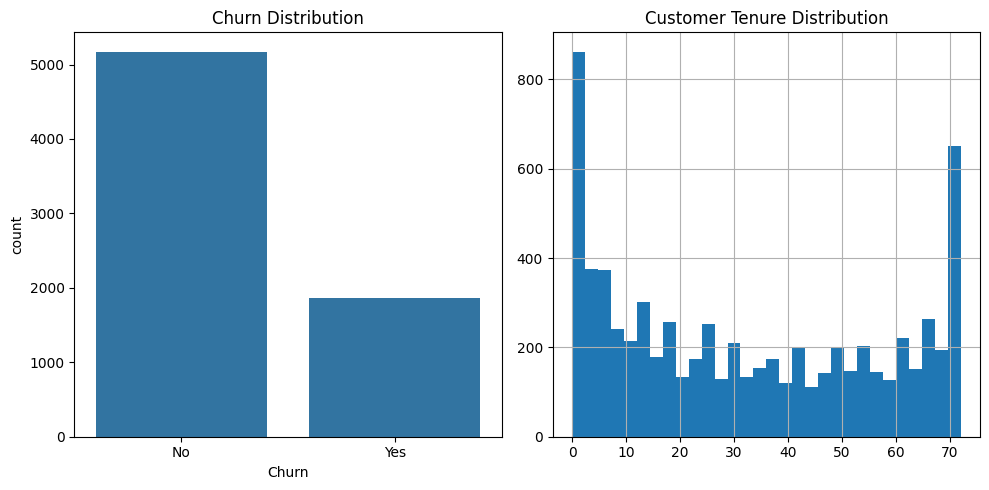

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (download from Kaggle first)
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Data Cleaning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Quick EDA
print("Dataset shape:", df.shape)
display(df.head(3))

# Visualize churn distribution
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(data=df, x='Churn')
plt.title("Churn Distribution")

plt.subplot(1,2,2)
df['tenure'].hist(bins=30)
plt.title("Customer Tenure Distribution")
plt.tight_layout()
plt.show()

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create new feature
df['AvgChargePerTenure'] = df['TotalCharges'] / (df['tenure'] + 1)

# Select features
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})

# Preprocessing pipeline
numeric_features = ['tenure', 'MonthlyCharges', 'AvgChargePerTenure']
categorical_features = ['Contract', 'PaymentMethod', 'InternetService']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)  # Fixed parameter
    ])

# Split data
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    scale_pos_weight=np.sum(y==0)/np.sum(y==1),  # Handle class imbalance
    eval_metric='aucpr',
    random_state=42
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [5]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()
h2o_df = h2o.H2OFrame(pd.concat([pd.DataFrame(X_processed), y.reset_index(drop=True)], axis=1))
train, test = h2o_df.split_frame(ratios=[0.8])

aml = H2OAutoML(
    max_models=5,
    seed=42,
    exclude_algos=["DeepLearning"],  # Optional: exclude slow algorithms
    balance_classes=True
)
aml.train(y='Churn', training_frame=train)

print(aml.leaderboard)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,9 mins 46 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_Mohammad_dshhig
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.588 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
17:44:50.563: AutoML: XGBoost is not available; skipping it.
17:44:50.566: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
17:44:50.757: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
17:44:51.172: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.
17:44:52.568: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a

\n=== XGBoost Performance ===
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1035
           1       0.51      0.73      0.60       374

    accuracy                           0.75      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.79      0.75      0.76      1409



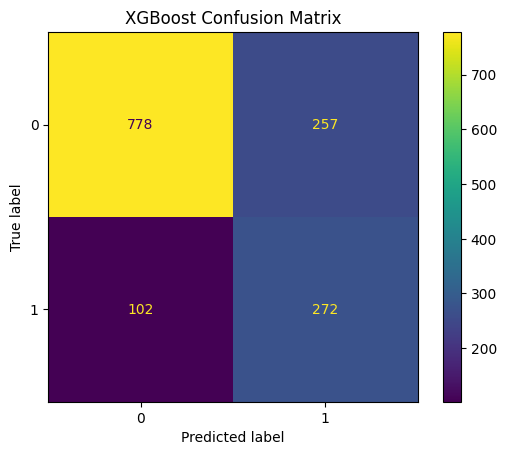

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\Users\Mohammad\Desktop\Data Projects\.venv\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


\n=== AutoML Leader Performance ===


c:\Users\Mohammad\Desktop\Data Projects\.venv\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [6]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# XGBoost Evaluation
print("\\n=== XGBoost Performance ===")
print(classification_report(y_test, xgb_model.predict(X_test)))

ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("XGBoost Confusion Matrix")
plt.show()

# AutoML Evaluation
aml_leader = aml.leader
aml_preds = aml_leader.predict(test).as_data_frame()
print("\\n=== AutoML Leader Performance ===")
print(classification_report(test['Churn'].as_data_frame(), aml_preds['predict']))

c:\Users\Mohammad\Desktop\Data Projects\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


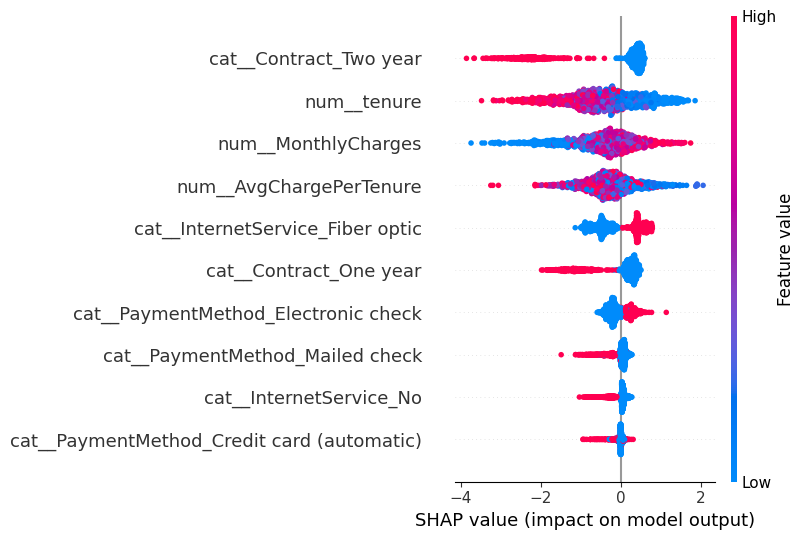

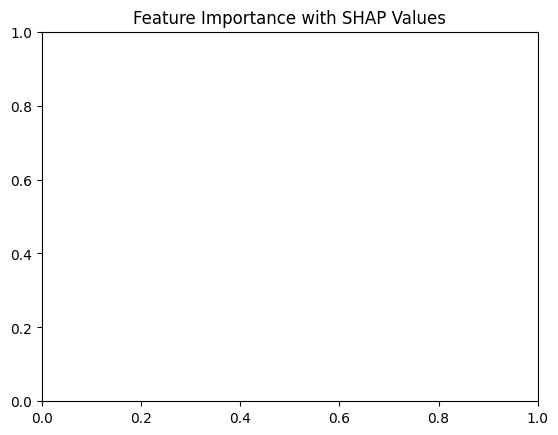

In [8]:
import shap

# Explain XGBoost predictions
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test, feature_names=preprocessor.get_feature_names_out())
plt.title("Feature Importance with SHAP Values")
plt.show()

In [9]:
import joblib

# Save preprocessing pipeline and model
joblib.dump({
    'preprocessor': preprocessor,
    'model': xgb_model
}, 'churn_predictor.pkl')

print("Model saved as churn_predictor.pkl")

Model saved as churn_predictor.pkl
